# Objective
- base, Grid-Search-CV, Random-Search-CV models without oversampling
- base, Grid-Search-CV, Random-Search-CV models with oversampling

In [ ]:
import warnings
from collections import Counter
from importlib import reload

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

import custom_libs.evaluation_helper as ev
import models.uci_heart_disease_dataset as uci

warnings.filterwarnings("ignore")

In [ ]:
# Load the preprocessed dataset (299 records; with 14 features).
data = pd.read_csv(uci.UCIHeartDiseaseDataFile.cleveland_preprocessed, names = uci.get_standard_features())
print(f'Data shape: {data.shape}.')
data.head(3)

### Parameters for SVM

In [16]:
# Verbose variable for log inspection.
verbose = False

# Dictionary to hold hyperparameters for grid search.
parameters = dict()
# The function to measure the quality of a split
parameters['criterion'] = ['gini', 'entropy']
# Class Weight
parameters['class_weight'] = ['balanced', 'dict']

# Number of trees in random forest
parameters['n_estimators'] = arange(200, 1000, 200)

# Number of features to consider at every split
parameters['max_features'] = ['auto', 'sqrt']

# Maximum number of levels in tree
parameters['max_depth'] = arange(10, 110, 10)

# Minimum number of samples required to split a node
parameters['min_samples_split'] = [2, 5, 10]

# Minimum number of samples required at each leaf node
parameters['min_samples_leaf'] = [1, 2, 4]

# Method of selecting samples for training each tree
parameters['bootstrap'] = [True, False]


# A stratified K fold for cross validation strategy - values are assigned from the global class.
skfolds = StratifiedKFold(n_splits = ev.kfold_n_split,
                          shuffle = ev.kfold_shuffle,
                          random_state = ev.random_state)

# Reset accuracies for SVM
ev.accuracies = {}

### Base Model (Function)

In [ ]:
reload(ev)
# A function to build base model.
# Acknowledgement: Code was referenced from Prof. Mafas Raheem's AML lab-8.
def build_and_validate_base_model(x_set, y_set, test_name):
    # Calls the evaluation helper module to Scale and do train/test split.
    x_train, x_test, y_train, y_test = ev.scale_and_split(x_set, y_set)

    print(f'\nEvaluation name: {test_name}.')

    # Train the model with training set.
    rf= RandomForestClassifier(verbose=verbose)
    rf.fit(x_train, y_train)

    # Display the best hyperparameters and score.
    print(f'Params         :{ rf.get_params()}.')

    # Do prediction with the train model.
    y_pred = rf.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve
    ev.display_validation_report(y_test, y_pred, x_test, rf, test_name)

### Grid Search CV (Function)

In [17]:
reload(ev)
# A function to build and fine tune model using GridSearchCV.
# Acknowledgement: Code was referenced from Prof. Mafas Raheem's AML lab-10.
def build_and_validate_with_grid_search_cv(x_set, y_set, test_name):
    # Calls the evaluation helper module to Scale and do train/test split.
    x_train, x_test, y_train, y_test = ev.scale_and_split(x_set, y_set)

    print(f'\nEvaluation name: {test_name}.')

    rf= RandomForestClassifier(verbose=verbose)

    ## Building Grid Search with stratified k fold strategy for cross-validation.
    grid_scv = GridSearchCV(rf, parameters, scoring='accuracy', cv=skfolds)

    # Train and discover the model's best hyperparameters for optimal performance.
    grid_scv.fit(x_train,y_train)

    # Display the best hyperparameters and score.
    print(f'Best params          :{grid_scv.best_params_}.')
    print(f'Best score (*mean)   :{grid_scv.best_score_}.')

    # Predict using the trained model.
    y_pred = grid_scv.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve
    ev.display_validation_report(y_test, y_pred, x_test, grid_scv, test_name)

### Random Search CV (Function)

In [ ]:
reload(ev)
# A function to build and fine tune model using RandomSearchCV.
# Acknowledgement: Code was referenced from Prof. Mafas Raheem's AML lab-10.
def build_and_validate_with_random_search_cv(x_set, y_set, test_name):
    # Calls the evaluation helper module to Scale and do train/test split.
    x_train, x_test, y_train, y_test = ev.scale_and_split(x_set, y_set)

    print(f'\nEvaluation name: {test_name}.')

    rf = RandomForestClassifier(verbose=verbose)

    ## Building Random Search algorithm with cross-validation and acc score.
    rand_scv = RandomizedSearchCV(rf, parameters, scoring='accuracy', cv=skfolds)

    # Train and discover the model's hyperparameters for optimal result.
    rand_scv.fit(x_train,y_train)

    # Display the best hyperparameters and score.
    print(f'Best params :{rand_scv.best_params_}.')
    print(f'Best score  :{rand_scv.best_score_}.')

    # Predict using the trained model.
    y_pred = rand_scv.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve
    ev.display_validation_report(y_test, y_pred, x_test, rand_scv, test_name)

## Evaluation with Standard Dataset (without over-sampling)

### Data Preparation

In [18]:
# Prepare features and target variables.
X = data.drop(uci.UCIHeartDiseaseData.target, axis=1)
y = data[uci.UCIHeartDiseaseData.target]

In [ ]:
# Evaluation: Standard Base
build_and_validate_base_model(X, y,ev.EvaluationType.std_base)

In [19]:
# Evaluation: Standard Grid Search CV
build_and_validate_with_grid_search_cv(X, y, ev.EvaluationType.std_grid_search_cv)


Evaluation name: std-grid-scv.


KeyboardInterrupt: 


Evaluation name: std-rand-scv.
Best params :{'n_estimators': 900, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'entropy', 'class_weight': 'balanced', 'bootstrap': True}.
Best score  :0.8118794326241134.

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        32
           1       0.92      0.86      0.89        28

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60


Confusion Matrix


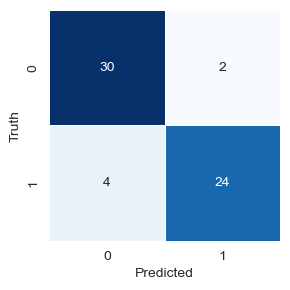

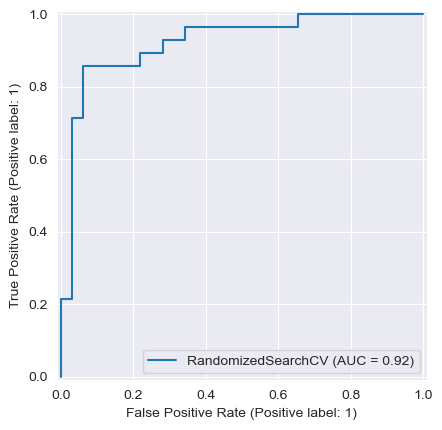

In [14]:
# Evaluation: Standard Random Search CV
build_and_validate_with_random_search_cv(X, y, ev.EvaluationType.std_random_search_cv)

In [ ]:
print(ev.accuracies)

## Evaluation with Over-sampled Dataset

### Data Preparation and Over-sampling

In [ ]:
# Prepare features and target variables.
X = data.drop(uci.UCIHeartDiseaseData.target, axis=1)
y = data[uci.UCIHeartDiseaseData.target]

# Perform over-sampling with SMOTE
X_b, y_b = SMOTE().fit_resample(X, y)
print(f'Classes before over-sampling :{Counter(data[uci.UCIHeartDiseaseData.target])}.')
print(f'Classes after over-sampling  :{Counter(y_b)}.')

In [ ]:
# Before over-sampling
plt.subplots(figsize=(5,5))
sns.countplot(x=data[uci.UCIHeartDiseaseData.target])

# After over-sampling
plt.subplots(figsize=(5,5))
sns.countplot(x=y_b)

In [ ]:
# Evaluation: Over-sampled Base
build_and_validate_base_model(X_b, y_b,ev.EvaluationType.os_base)

In [ ]:
# Evaluation: Over-sampled Grid Search CV
build_and_validate_with_grid_search_cv(X_b, y_b, ev.EvaluationType.os_grid_search_cv)

In [ ]:
# Evaluation: Over-sampled Random Search CV
build_and_validate_with_random_search_cv(X_b, y_b, ev.EvaluationType.os_random_search_cv)

In [ ]:
print(ev.accuracies)

## Conclusion

In [ ]:
plt.bar(range(len(ev.accuracies)), list(ev.accuracies.values()), align='center')
plt.xticks(range(len(ev.accuracies)), list(ev.accuracies.keys()))

plt.show()

In [ ]:
### Register the highest in global
ev.global_accuracies['SVM'] = 87